---
title: Implementing the Perceptron
author: Sophie Seiple
date: '2024-03-28'
image: "perceptron.png"
description: "Implementing and testing the perceptron algorithm."
format: html
---

## Abstract

In this blog post, I explore the implementation and experimentation of the perceptron algorithm. Beginning with an implementation of the algorithm itself in the file [perceptron.py](https://github.com/esseiple/esseiple.github.io/blob/main/posts/perceptron/perceptron.py), I then explore its functionality and effectiveness through various experiments. Through code implementation and visualizations, I demonstrate the algorithm's behavior on both linearly separable and non-linearly separable data in 2D, as well as its extension to greater dimensions. Additionally, I explore the mini-batch perceptron algorithm and its impact on convergence and performance. Throughout this blog post I learned a lot about the advantages and disadvantages of the perceptron algorithm on various kinds of data.

In [8]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Linearly Separable Experiments

My first step, after implementing the perceptron class, was to test my work on known linearly seperable data. I used the code from [lecture 7](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html) to generate linearly seperable data and a visualization of said data.

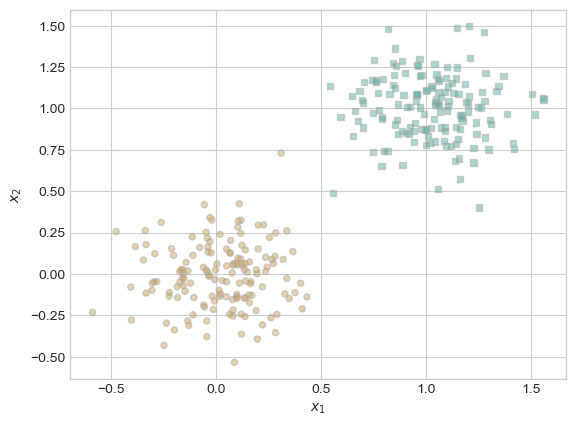

In [9]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

# function which creates linearly seperable data
def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

# creating data instance
X, y = perceptron_data(n_points = 300, noise = 0.2)

# function that plots perceptron data
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

This graph shows a clear distinction between labels in the data that can be easily divided by a single line.

In [10]:
# My classmate Lindsey Schweitzer's idea to create a plot_loss function for easier plotting
def plot_loss(loss):

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))


    plt.plot(loss, color = "slategrey")
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "loss")
    
    plt.title(f"Final loss: {loss[len(loss)-1]:.3f}")

I then ran an update cycle on the data, continuing to update the weights until the total loss reached 0.0 (since I knew the data would eventually reach this point).

In [ ]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

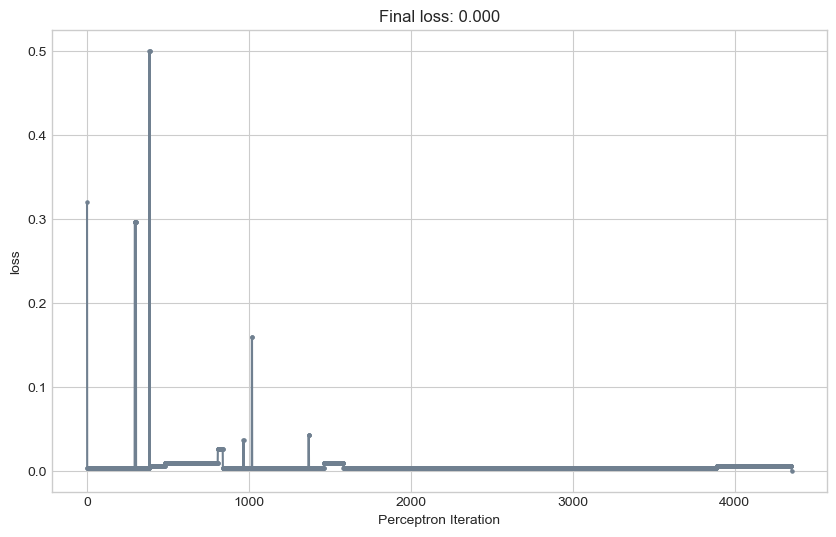

In [ ]:
plot_loss(loss_vec)

This did indeed find that the data was linearly separable, and that my perceptron class and implementation was able to successfully find that separating line. 

### Visualizing Perceptron's Process

I adapted code, again from [lecture 7](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html) to visualize a few specific steps of the perceptron algorithm, showing how the line changes as the weights are updated until it eventually finds where loss is equal to zero. 

In [ ]:
# function from lec 7 to add line to plot
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

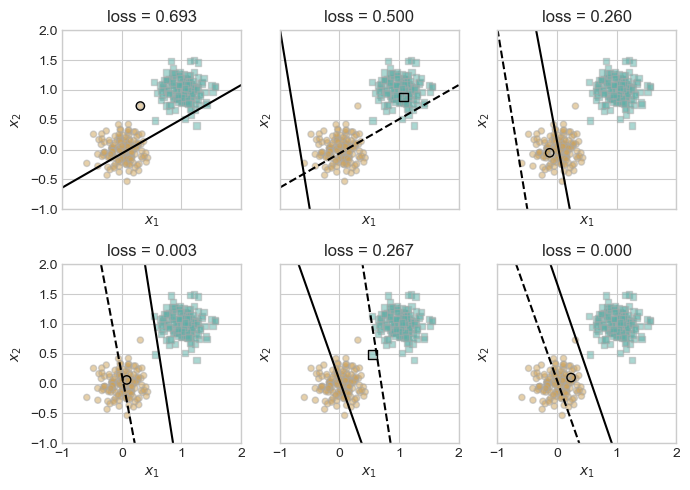

In [ ]:
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # find i, random data point
    i = torch.randint(n, size=(1,))

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    local_loss = opt.step(X[[i],:], y[i])

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

## Non-Linearly Separable Experiments

Next, I tested my perceptron against data that I know to be non-linearly separable to see how it would perform. For this purpose, I created a function that creates data that cannot be separated by a single line.

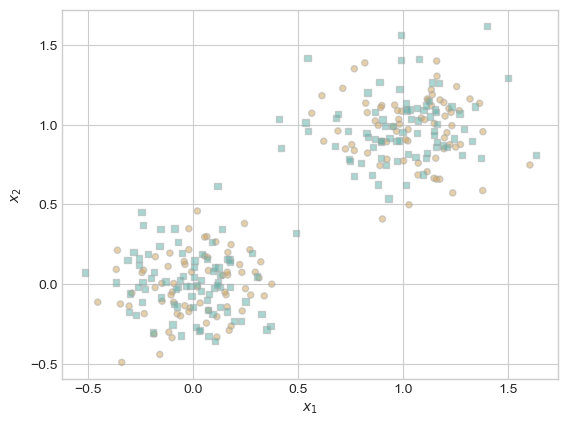

In [13]:
# creates non-linearly separable data
def perceptron_data_nonlinear(n_points = 300, noise = 0.2, p_dims = 2):
    
    # same as the linearly seperable data
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # add random noise to y
    y = y ^ (torch.randint(0, 2, size=(n_points,)).bool())

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data_nonlinear()
plot_perceptron_data(X, y, ax)

Clearly, looking at this data, there is no easy way to classify points using a perceptron-generated line. Next, I used my perceptron update algorithm on an instance of this data, to see how the loss would change over the iterations. In order to prevent looping forever, as the loss will never reach 0.0, I instead limited the algorithm to 1000 iterations.

In [ ]:
X, y = perceptron_data_nonlinear()

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []
weights = []

n = X.size()[0]

maxit = 1000 # max iterations

while maxit > 0: 
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    weights.append(torch.clone(p.w))

    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    maxit-=1

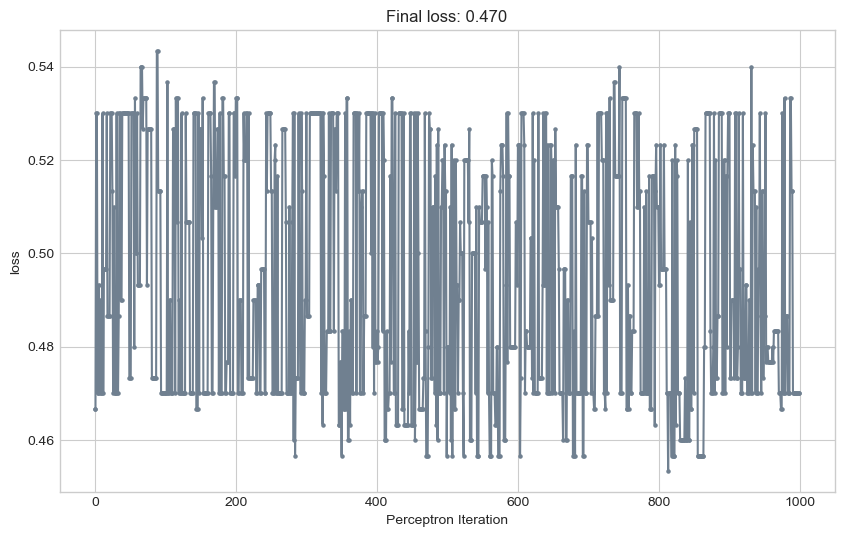

In [ ]:
plot_loss(loss_vec)

The algorithm is obviously struggling with this unseparable data, and isn't able to land anywhere close to a 0.0 loss like it did for our previous data. After 1000 iterations it found a final loss of 0.47.

### Visualizing Perceptron's Last Move

Like for the linearly separable perceptron, I wanted to visualize the line my perceptron had drawn on the data. In this case, since there was build-up in terms of the line approaching a better separation as in the linear data, I just visualized the very last loss found.

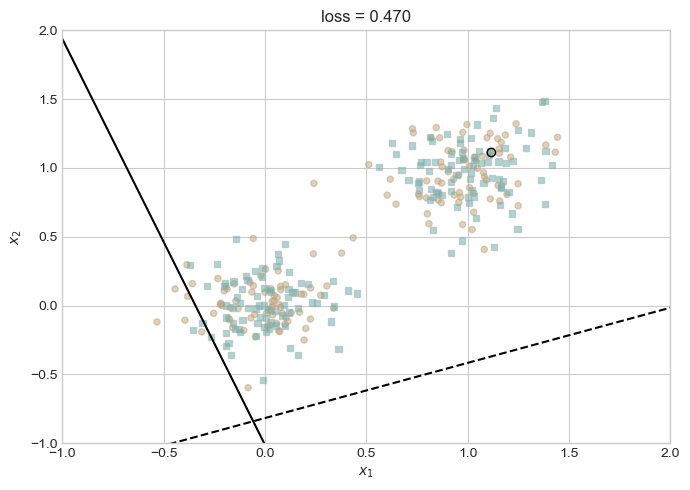

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)
draw_line(weights[-2], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
# draw_line(w, -10, 10, ax, color = "black")
ax.set_title(f"loss = {loss_vec[-1]:.3f}")
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plt.tight_layout()

## Data with 5 Dimensions

To test whether the data is linearly seperable in the case of higher dimensions, I set the dimension to 5 for the creation of the data (using the regular, theoretically linearly-separable function), and ran the same perceptron algorithm and visualization process. I again used an iteration max instead of a loop until loss = 0, as I wasn't sure whether or not the data would end up being linearly separable.

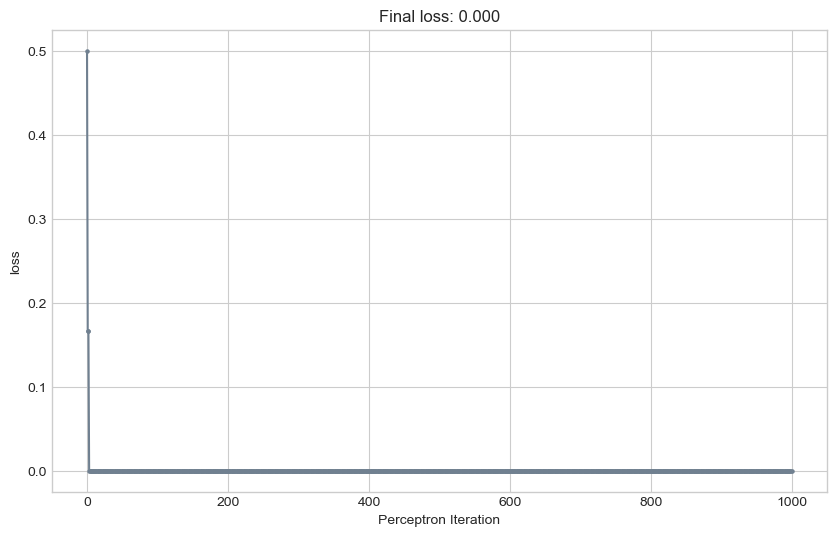

In [ ]:
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=5)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

maxit = 1000

while maxit > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    maxit-=1
    
plot_loss(loss_vec)

Interestingly, I found that the data in 5-dimensions was in fact linearly seperable within 1000 perceptron iterations. I noticed though, that upon increasing the noise in the data to 0.5 and above, the data become non-linearly seperable. The visualization of that noisier data is below.

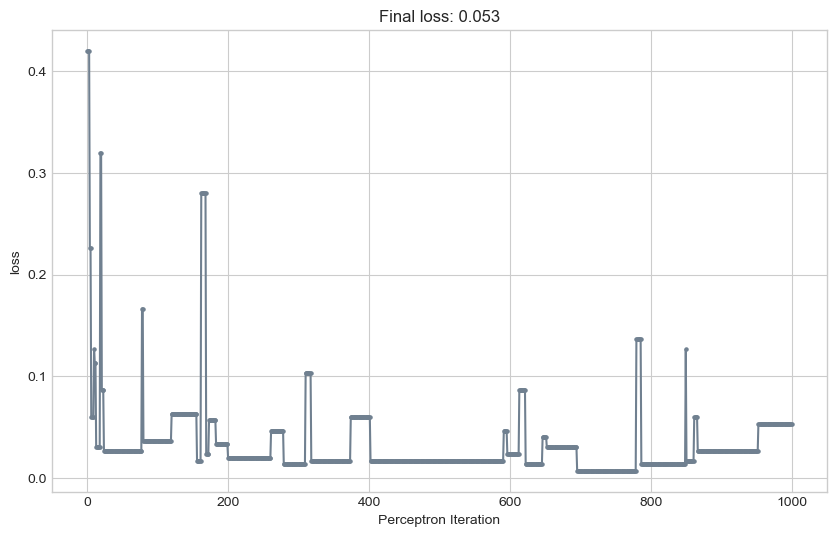

In [ ]:
X, y = perceptron_data(n_points = 300, noise = 0.5, p_dims=5)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

maxit = 1000

while maxit > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    maxit-=1
    
plot_loss(loss_vec)

With noise set to 0.5, the algorithm could only reach a final loss of 0.053.

## Mini-Batch Implementation

Next, I implemented the mini-batch perceptron algorithm, which computes a perceptron update using k points at once, rather than a single point. It also involves a hyper-parameter $\alpha$, which is the learning rate, and determines how quickly the weight vectors change over iterations.

In [ ]:
from perceptron_minibatch import PerceptronMB, PerceptronMBOptimizer

### K = 1 for Linearly and Non-Linearly Separable Data

My first experiment was performing the algorithm for k = 1, so essentially recreating a regular update step with a single random point, for both linearly and non-linearly separable data.

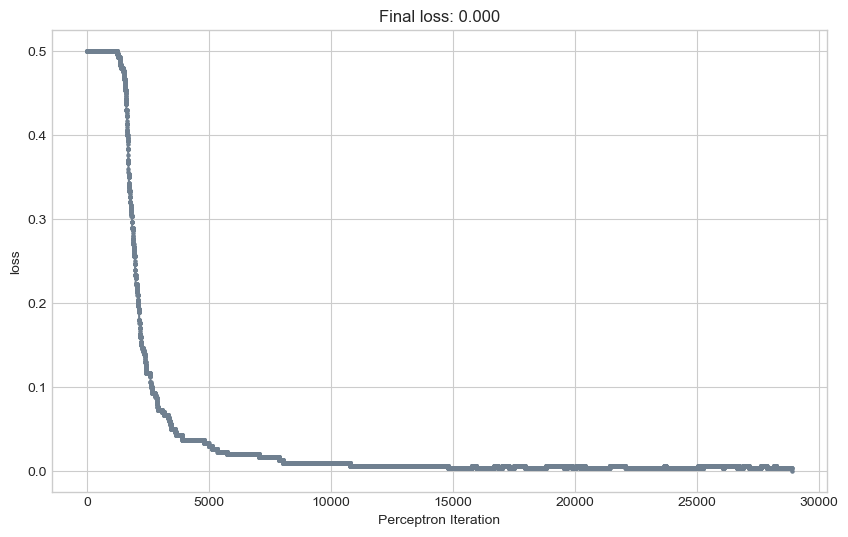

In [ ]:
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=2)

torch.manual_seed(1234567)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable

    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)

    # get a random submatrix of the feature matrix X and target vector y to implement minibatch
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plot_loss(loss_vec)

I found that the mini-batch algorithm was able to converge with linearly separable data much like the regular perceptron algorithm.

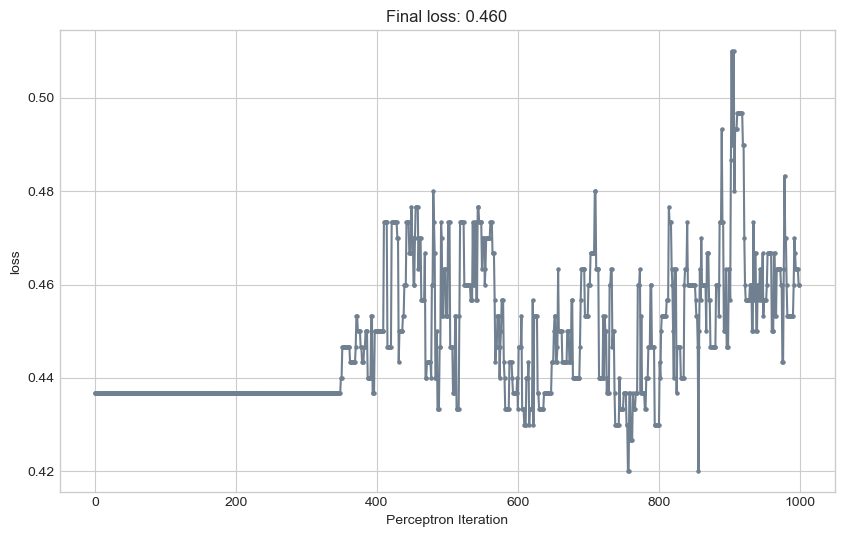

In [ ]:
X, y = perceptron_data_nonlinear(n_points = 300, noise = 0.2, p_dims=2)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []
weights = []

n = X.size()[0]

maxit = 1000 # max iterations

while maxit > 0: 
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    weights.append(torch.clone(p.w))

    
    # get a random submatrix of the feature matrix X and target vector y to implement minibatch
    k = 1
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    maxit-=1

plot_loss(loss_vec)

For non-linear data, I, again just as in the regular perceptron update, found that the algorithm wasn't able to converge to loss equals zero.

### K = 10 for Linearly and Non-Linearly Separable Data

Next, I tested the algorithm when it chose 10 random points in its update step, again for both linearly and non-linearly separable data.

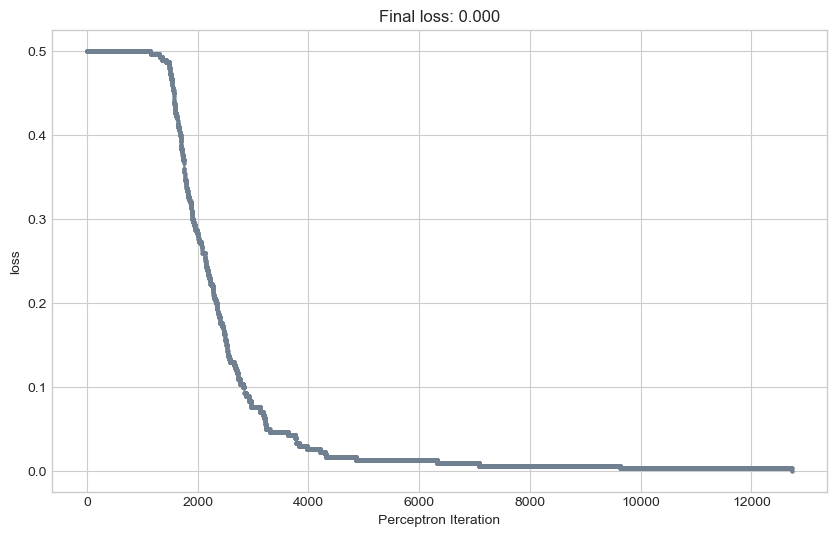

In [ ]:
X, y = perceptron_data(n_points = 300, noise = 0.2, p_dims=2)

torch.manual_seed(1234567)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable

    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)

    # get a random submatrix of the feature matrix X and target vector y to implement minibatch
    k = 10
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plot_loss(loss_vec)

The algorithm was able to find loss = 0.0 for linearly separable data as expected.

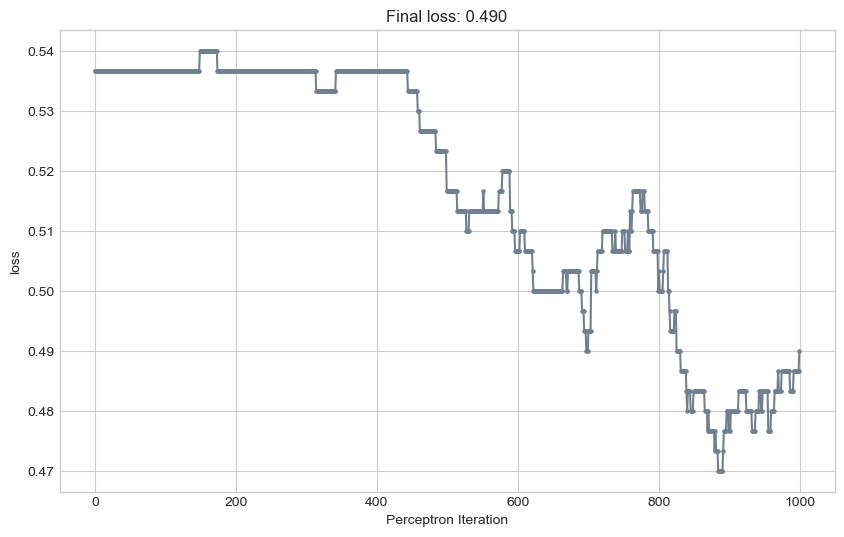

In [ ]:
X, y = perceptron_data_nonlinear(n_points = 300, noise = 0.2, p_dims=2)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []
weights = []

n = X.size()[0]

maxit = 1000 # max iterations

while maxit > 0: 
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    weights.append(torch.clone(p.w))

    
    # get a random submatrix of the feature matrix X and target vector y to implement minibatch
    k = 10
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    maxit-=1

plot_loss(loss_vec)

Also as expected, the algorithm was not able to find loss = 0.0 for non-linearly separable data.

### K = N for Non-Linearly Separable Data

Lastly, I checked whether, with k = n, in other words when the entire dataset is considered in a single update, the algorithm was able to converge even in the case of non-linearly separable data.

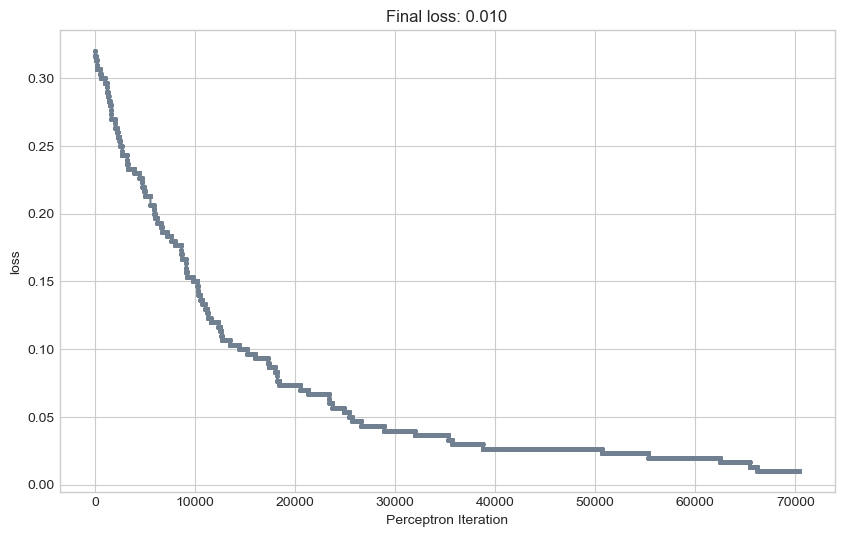

In [14]:
torch.manual_seed(1234567)

X, y = perceptron_data_nonlinear()

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)

# for keeping track of loss values
loss_vec_mini = []

n = X.size()[0]

for index in range(0, 1000):
    
    # K is n
    k = n
    
    # get a random submatrix of the feature matrix X and target vector y to implement mini-batch
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec_mini.append(loss)

plot_loss(loss_vec)

Interestingly, I found that the algorithm was able to converge to close to zero (0.010) even with non-linearly separable data using k = n. I did have to adjust the learning rate to be very small (0.0001), in order for this to be possible.

## Perceptron Algorithm Runtime Analysis

A single iteration of the perceptron algorithm involved taking the dot product of w, the weight vector, and any row of the feature matrix. This computation depends on the number of elements in each row of the feature matrix, i.e. the dimension of the feature matrix, p. A single iteration of the perceptron algorithm therefore takes $O(p)$.

A single iteration of the mini-batch perceptron algorithm involved taking the dot product of k points instead of just one. Therefore the runtime of a single iteration of the mini-batch algorithm is $O(k \cdot p)$

## Discussion

Through this blog post, I gained valuable insights into strengths and limiations of perceptron algorithm. I successfully implemented the perceptron algorithm, both the regular and mini-batch versions. I performed experiments to validate the accuracy of my implementation, allowing me to grasp the nuances of perceptron updates and its behavior across diverse data types, including higher dimensions and non-linearly separable data. By exploring the mini-batch approach, I demonstrated its functionality akin to a single-point process with k = 1, its effectiveness in identifying separating lines in linearly separable data with k=10, and its ability to converge even in the absence of linear separability when k=n.